In [4]:
library(foreach)

Create data from the following experiment:

- The treatment has a higher effect on people older than 31.
- Optional:People are more likely to be available for treatment when they are under 31.

In [44]:
make_experiment <- function(n=100, treatment_prob){
    response <- integer()
    group <- integer()
    tau <- numeric()
    
    X <- runif(n = n, 21,40)

    if(length(treatment_prob)==1){
        if(treatment_prob=="age"){
              treatment_prob = ifelse(X>31, 0.3, 0.7)
        }else{
              treatment_prob <- rep(treatment_prob,n)
    }}
    
    for(i in 1:n){
        group[i] <- rbinom(n = 1, size = 1, prob = treatment_prob[i])
        tau[i] <- ifelse(X[i] > 31, rnorm(1, mean = 0.3, sd = 0.01), rnorm(1, mean = 0.1, sd = 0.01))
        if(group[i] == 1){
            response[i] <- rbinom(n = 1, size = 1, prob = 0.3 + tau[i])
        }else{
            response[i] <- rbinom(n = 1, size = 1, prob = 0.3)
        }
        }

    data <- data.frame(response, group, X, treatment_prob, tau)
    
    return(data)
}

In [45]:
data <- make_experiment(2000, 0.5)

sum(data$group==1)
sum(data$group==0)

mean(data$response[data$group==1])
mean(data$response[data$group==0])

[1] 980

[1] 1020

[1] 0.5061224

[1] 0.3147059

In [46]:
summary(data)

    response          group            X         treatment_prob
 Min.   :0.0000   Min.   :0.00   Min.   :21.01   Min.   :0.5   
 1st Qu.:0.0000   1st Qu.:0.00   1st Qu.:25.63   1st Qu.:0.5   
 Median :0.0000   Median :0.00   Median :30.40   Median :0.5   
 Mean   :0.4085   Mean   :0.49   Mean   :30.48   Mean   :0.5   
 3rd Qu.:1.0000   3rd Qu.:1.00   3rd Qu.:35.39   3rd Qu.:0.5   
 Max.   :1.0000   Max.   :1.00   Max.   :40.00   Max.   :0.5   
      tau         
 Min.   :0.07255  
 1st Qu.:0.09907  
 Median :0.11618  
 Mean   :0.19391  
 3rd Qu.:0.29973  
 Max.   :0.32915  

Intuition: We look at how often we get a response in the group with treatment and compare this number to how often we get a response without treatment.

In [47]:
sum(data$response[data$group==1])
sum(data$response[data$group==0])
sum(data$response*data$group) - sum(data$response*(1-data$group))


[1] 496

[1] 321

[1] 175

Or as a difference of ratios

In [48]:
sum(data$response[data$group==1])/1000
sum(data$response[data$group==0])/1000
sum(data$response*data$group)/1000 - sum(data$response*(1-data$group))/1000


[1] 0.496

[1] 0.321

[1] 0.175

## Average treatment effect under equiprobable sampling

The treatment effect is defined as 
$$ ATE = \mathbf{E}[y(Treatment) - y(Control)] \\
       = \mathbf{E}[y(Treatment)] - \mathbf{E}[y(Control)] $$

The fundamental problem of causal inference is that we cannot observe the same observation $i$ both with and without treatment. But we can collect data to estimate the the expected response with and without treatment.

$$ \hat{ATE} = \hat{\mathbf{E}}[y(Treatment)] - \hat{\mathbf{E}}[y(Control)] $$

If individuals are exchangeable, i.e. there are no structural differenes between the invidiuals in the treatment and controls groups, then a good estimator for the expectation of a random variable is its mean

$$ \hat{ATE} = \frac{1}{N_{Treatment}} \sum_{i\in {Treatment}}\{ {y_i 1_{Group=Treatment}} \}
       - \frac{1}{N_{Control}}   \sum_{i\in {Control}}\{ {y_i 1_{Group=Control}}   \}$$

In [49]:
simple_ATE <- function(response, group){
    mean(response[group==1]) - mean(response[group==0])
}

In [50]:
simple_ATE(data$response, data$group)

[1] 0.1914166

## Inverse propensity weighting

Mostly harmless econometrics (p.60, equation 3.3.11)

\begin{align}
 \mathbf{E} &= \mathbf{E}\left[\frac{Y_i D_i}{p(X_i)} - \frac{Y_i(1-D_i}{1-p(X_i)} \right] \\
  &=\mathbf{E}\left[ \frac{(D_i - p(X_i))Y_i}{p(X_i)(1-p(X_i)}  \right]
\end{align}

In [51]:
propensity_corrected_ATE <- function(response, group, propensity_score){
    mean( 
        ((group - propensity_score) * response) /
        (propensity_score * (1-propensity_score))
    )
}

Assume our experiment assigns treatment randomly, but with a low probability. 

In [52]:
treatment_ratio <- rep(0.05, 1000)

In [34]:
exp <- foreach(i=1:200, .combine = rbind) %do%{

data <- make_experiment(1000, treatment_ratio)

cbind("simple"=simple_ATE(data$response, data$group),
      "corrected"=propensity_corrected_ATE(data$response, data$group, 
                                           propensity_score = treatment_ratio)
      )
}

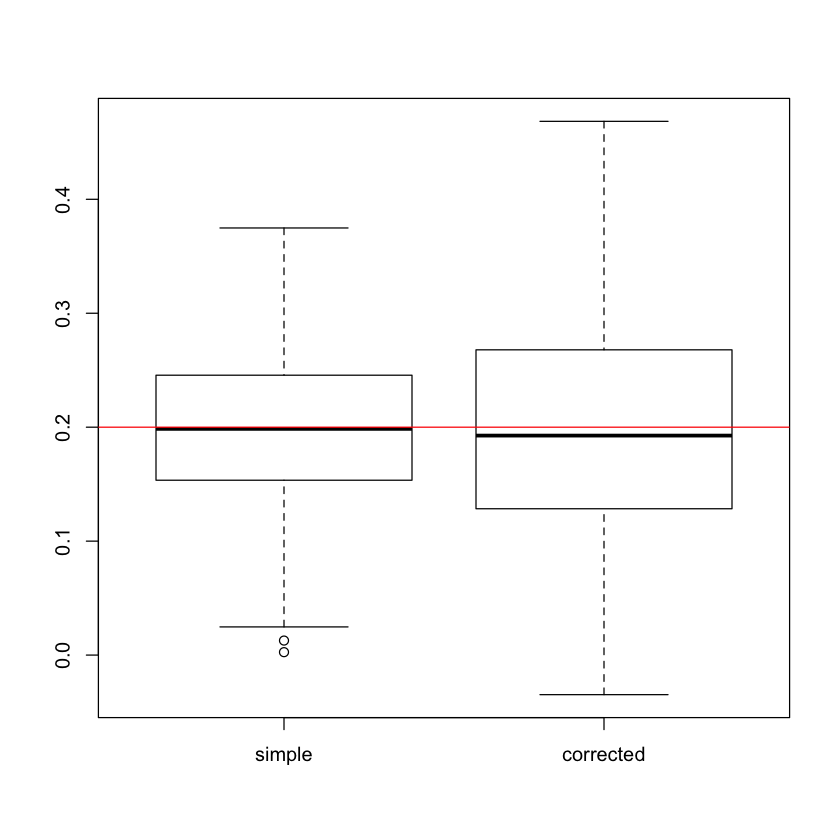

In [35]:
boxplot(exp)
abline(h=0.2, col="red")

## Inverse propensity weighting with individual treatment probability

Now let's assume that people over 31 are less likely to receive treatment.

In [54]:
data <- make_experiment(1000, treatment_prob="age")
summary(data[data$X>31,])
summary(data[data$X<31,])

    response          group              X         treatment_prob
 Min.   :0.0000   Min.   :0.0000   Min.   :31.13   Min.   :0.3   
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:33.18   1st Qu.:0.3   
 Median :0.0000   Median :0.0000   Median :35.44   Median :0.3   
 Mean   :0.3718   Mean   :0.2821   Mean   :35.52   Mean   :0.3   
 3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.:37.95   3rd Qu.:0.3   
 Max.   :1.0000   Max.   :1.0000   Max.   :39.99   Max.   :0.3   
      tau        
 Min.   :0.2629  
 1st Qu.:0.2932  
 Median :0.2990  
 Mean   :0.2991  
 3rd Qu.:0.3053  
 Max.   :0.3307  

    response          group              X         treatment_prob
 Min.   :0.0000   Min.   :0.0000   Min.   :21.02   Min.   :0.7   
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:23.69   1st Qu.:0.7   
 Median :0.0000   Median :1.0000   Median :26.15   Median :0.7   
 Mean   :0.3402   Mean   :0.6992   Mean   :26.14   Mean   :0.7   
 3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.:28.61   3rd Qu.:0.7   
 Max.   :1.0000   Max.   :1.0000   Max.   :30.99   Max.   :0.7   
      tau         
 Min.   :0.07219  
 1st Qu.:0.09340  
 Median :0.10018  
 Mean   :0.10008  
 3rd Qu.:0.10655  
 Max.   :0.12682  

In [55]:
exp <- foreach(i=1:200, .combine = rbind) %do%{

     data <- make_experiment(2000, treatment_prob="age")

     out <- cbind("simple"=simple_ATE(data$response, data$group),
                  "corrected"=propensity_corrected_ATE(data$response, data$group, 
                                           propensity_score = data$treatment_prob)
      )
}

Not correcting for the indvidual (as in "age group specific") chance to receive treatment AKA propensity score will return a biased treatment effect estimate. The treated group contains more young people, on which the treatment has a lower effect.

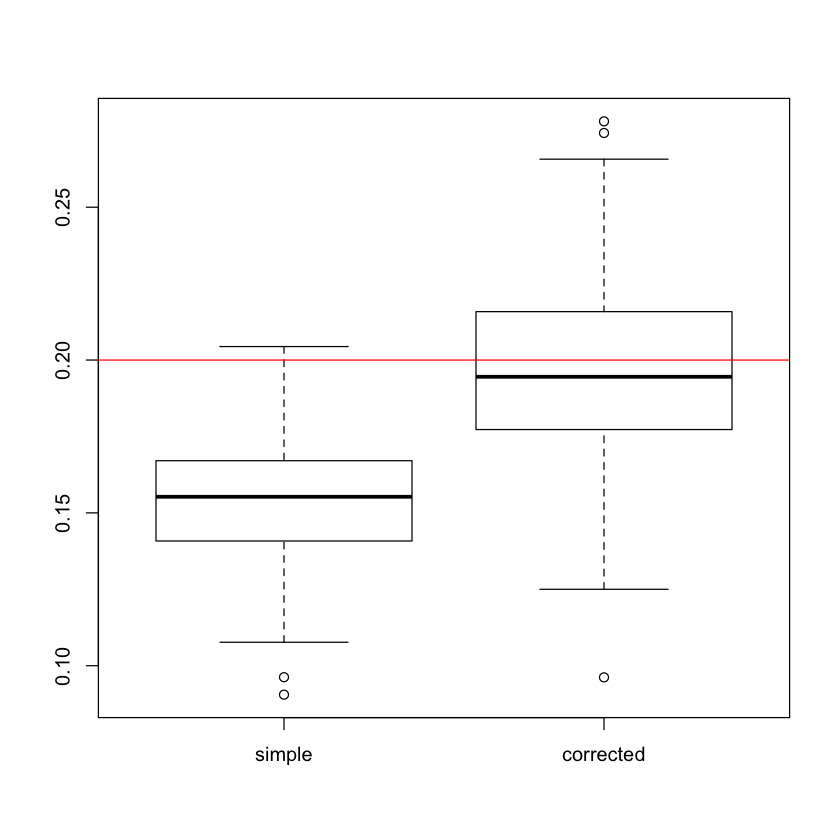

In [56]:
boxplot(exp)
abline(h=0.2, col="red")